In [ ]:
# ! pip install constrainedlr

In [512]:
import cv2 as cv
import seaborn as sns
import shutil
import time
import scipy
import os
import glob
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage import morphology as morph
from scipy.optimize import curve_fit, least_squares
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RANSACRegressor, LinearRegression
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from sklearn.preprocessing import PolynomialFeatures
from skimage.morphology import footprints, disk

from constrainedlr.model import ConstrainedLinearRegression

join = os.path.join

homeDir = "/Users/fabianyii/Desktop/masks/"
d1 = pd.read_csv(join(homeDir,"OD_fovea_parameters.csv"))
d2 = pd.read_csv(join(homeDir,"fovea_intensity_data.csv"))
d2 = d2.rename(columns={'fundus': 'name'})
d = pd.merge(d1, d2, left_on='name', right_on='name')
names = list(d.name)

In [2]:
# vessel = "artery"
# subtype = "process"
# # folder = vessel + "_binary_" + subtype
# folder = "resized"

# old_filepaths_1 = sorted(glob.glob(join("individuals", "artery_vein_1", folder, '*.png')))
# old_filepaths_2 = sorted(glob.glob(join("individuals", "artery_vein_2", folder, '*.png')))
# old_filepaths_3 = sorted(glob.glob(join("individuals", "artery_vein_3", folder, '*.png')))
# old_filepaths_4 = sorted(glob.glob(join("individuals", "artery_vein_4", folder, '*.png')))
# old_filepaths_5 = sorted(glob.glob(join("individuals", "artery_vein_5", folder, '*.png')))

# new_path = join("artery_vein", "show_both")

In [3]:
# for old_path in tqdm(old_filepaths_1):
#     shutil.move(old_path, new_path)
# for old_path in tqdm(old_filepaths_2):
#     shutil.move(old_path, new_path)   
# for old_path in tqdm(old_filepaths_3):
#     shutil.move(old_path, new_path)
# for old_path in tqdm(old_filepaths_4):
#     shutil.move(old_path, new_path)
# for old_path in tqdm(old_filepaths_5):
#     shutil.move(old_path, new_path)    

In [4]:
# d1 = pd.read_csv('/Users/fabianyii/Desktop/feature_measurement_1/Combined_Vessel_Measurement.csv')
# d2 = pd.read_csv('/Users/fabianyii/Desktop/feature_measurement_2/Combined_Vessel_Measurement.csv')
# d3 = pd.read_csv('/Users/fabianyii/Desktop/feature_measurement_3/Combined_Vessel_Measurement.csv')
# d4 = pd.read_csv('/Users/fabianyii/Desktop/feature_measurement_4/Combined_Vessel_Measurement.csv')
# d5 = pd.read_csv('/Users/fabianyii/Desktop/feature_measurement_5/Combined_Vessel_Measurement.csv')
# combined = pd.concat([d1, d2, d3, d4, d5], ignore_index=True)
# combined.to_csv('/Users/fabianyii/Desktop/Combined_Vessel_Measurement.csv', index=False)

### Arcade analysis

In [1556]:
# name = names[347] # low hyperopia +1.00
# name = list(d[d.SER < -10].name)[72] # high myopia; ransac robust to outlier
# name = list(d[d.SER > 8].name)[92] # high hyperopia; ransac robust to outlier
# name = list(d[d.SER < -15].name)[14] # high myopia straight arcade
name = list(d[d.SER < -15].name)[18] # high myopia straight arcade
# name = list(d[d.SER > 5].name)[59] # high hyperopia parabolic
# name = list(d[d.SER < -5].name)[21] # high hyperopia 
name

'2448035_21015_0_0.png'

In [1557]:

!python main.py --image_name '2448035_21015_0_0.png' --show_preprocessing --show_ransac_parabola --fit_verbose --mark_vertex --vessel_path '/Users/fabianyii/Desktop/masks/artery_vein/vein/full_width'


#### RANSAC parabola : Excluded 272 outliers out of 961 vessel pixels ####
Concavity index: 0.0016
Top median residual: 15.5079
Bottom median residual: 13.8355
Median residual: 17.8568
R2: 0.9255


In [382]:

# python code/main.py --parallelisation --show_preprocessing --show_ransac_parabola --save_fig


In [ ]:
name = list(d[d.SER < -5].name)[19] # high hyperopia 

In [1558]:
def vessel_pixel_coordinates(mask):
    # Get foreground (i.e. vessel) pixel coordinates 
    boolean_array = np.where(mask > 0)
    coords = np.flip(np.column_stack(boolean_array), axis=1)
    return coords    

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
    return result

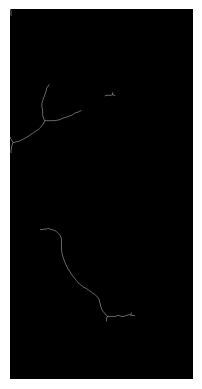

In [1560]:
import math
import imutils
from preprocess import arcade_detector
from arcade_model import parabola_ls, RANSAC
vessel_path = join(homeDir, "artery_vein", "vein", "full_width")
vessel = arcade_detector(name, vessel_path)

ori = vessel.mask
# angle = list(d[d.name == name].vertical_angle)[0]
# vessel.rotate_image(angle)

resize_ratio_width = vessel.size()[1] / 560
resize_ratio_height = vessel.size()[0] / 560
disc_x = np.float16(d[d.name == name].disc_x)[0] * resize_ratio_width
disc_y = np.float16(d[d.name == name].disc_y)[0] * resize_ratio_height
vessel.crop_around_disc(disc_x, disc_y)
s1 = vessel.mask
# fovea_x = list(d[d.name==name].fovea_x)[0] * resize_ratio_width
# fovea_y = list(d[d.name==name].fovea_y)[0] * resize_ratio_height
# vessel.crop_to_fovea(disc_x, disc_y, fovea_x, fovea_y, 50)
vessel.dist_transform()
s2 = vessel.mask
vessel.area_opening()
s3 = vessel.mask
vessel.detect_parabola()
s4 = vessel.mask
vessel.area_opening()
s5 = vessel.mask
vessel.rectangular_closing()
s6 = vessel.mask
vessel.skeleton()
s7 = vessel.mask

skeleton = np.uint8(vessel.mask*255)

vessel.view()


In [1564]:
class parabola(arcade_detector):
        def __init__(self, vertex_x, vertex_y):
            self.vertex_x = vertex_x
            self.vertex_y = vertex_y
            
        def quadratic_vertex_equation(self, y, concavity):
            # Quadratic function in vertex form
            return concavity*(y - self.vertex_y)**2 + self.vertex_x
        
        def fit(self, y, x):
            self.coefficients, _ = curve_fit(self.quadratic_vertex_equation, y, x, maxfev=1000)
            return self.coefficients
            
        def predict(self, y_input):
            return self.quadratic_vertex_equation(y_input, *self.coefficients)
        
        
class RANSAC(arcade_detector):
    def __init__(self, mask):
        self.mask = mask
        self.quadratic = PolynomialFeatures(degree=2)
          
###################### Parabola ########################
    def fit_full_parabola(self):
        # Get vessel coordinates
        coords = vessel_pixel_coordinates(self.mask)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.x_reshaped = self.x.reshape((-1, 1))
        self.y_reshaped = self.y.reshape((-1, 1))            
        self.y_quadratic_trans = self.quadratic.fit_transform(self.y_reshaped)
        self.full_parabola = RANSACRegressor(LinearRegression(fit_intercept=False), min_samples=10)
        self.full_parabola.fit(self.y_quadratic_trans, self.x_reshaped)
        # get coefficients
        self.c = self.full_parabola.estimator_.coef_[0, 0] 
        self.b = self.full_parabola.estimator_.coef_[0, 1] 
        self.concavity = self.full_parabola.estimator_.coef_[0, 2]  
        self.vertex_x, self.vertex_y = self.get_parabola_vertex(self.b, self.c, self.concavity)

    def fit_top_parabola(self):
        # Get top segment (include only inliers)
        top_seg = self.mask[0:round(disc_y),:]
        top_coords = vessel_pixel_coordinates(top_seg)
        top_inliers = self.full_parabola.inlier_mask_[0:len(top_coords)]
        self.top_seg_inliers = top_seg.copy()
        self.top_seg_inliers[self.top_seg_inliers > 0] = top_seg[top_seg > 0] * np.uint8(top_inliers)
        # Vertically flip it and combine it with the original top segment 
        top_seg_flipped = cv.flip(self.top_seg_inliers, 0)
        self.top_mask = np.concatenate((self.top_seg_inliers, top_seg_flipped))
        # Get the coordinates of the inliers
        coords = vessel_pixel_coordinates(self.top_mask)
        x_top = coords[:,0]
        y_top = coords[:,1]
        # Fit top segment
        origin_x = disc_x*(450/912)
        self.parabola_top = parabola(self.vertex_x, self.top_mask.shape[0]/2)
        self.coef_top = self.parabola_top.fit(y_top, x_top)  

    def fit_bottom_parabola(self):
        # Get bottom segment (include only inliers)
        bottom_seg = self.mask[round(disc_y):,:]
        bottom_coords = vessel_pixel_coordinates(bottom_seg)
        bottom_inliers = self.full_parabola.inlier_mask_[-len(bottom_coords):]
        self.bottom_seg_inliers = bottom_seg.copy()
        self.bottom_seg_inliers[self.bottom_seg_inliers > 0] = bottom_seg[bottom_seg > 0] * np.uint8(bottom_inliers)
        # Vertically flip it and combine it with the original bottom segment 
        bottom_seg_flipped = cv.flip(self.bottom_seg_inliers, 0)
        self.bottom_mask = np.concatenate((bottom_seg_flipped, self.bottom_seg_inliers))
        # Get the coordinates of the inliers
        coords = vessel_pixel_coordinates(self.bottom_mask)
        y_offset = disc_y - self.bottom_mask.shape[0]/2
        x_bottom = coords[:,0]
        y_bottom = coords[:,1] + y_offset
        # Fit bottom segment 
        self.parabola_bottom = parabola(self.vertex_x, self.bottom_mask.shape[0]/2 + y_offset)
        self.coef_bottom = self.parabola_bottom.fit(y_bottom, x_bottom)

    def display_full_parabola(self, mark_vertex=True):
        # Get predictions
        y_input = np.arange(0, ransac.mask.shape[0])
        y_input = y_input.reshape((-1,1))
        y_input_trans = self.quadratic.fit_transform(y_input)
        self.x_predicted = self.full_parabola.predict(y_input_trans)
        # Plot
        show_boolean = (self.x_predicted <= self.mask.shape[1]) & (self.x_predicted > 0)
        plt.plot(self.x_predicted[show_boolean], y_input.reshape((-1,1))[show_boolean], '--', color='red') 
        plt.plot(self.x[self.full_parabola.inlier_mask_], self.y[self.full_parabola.inlier_mask_], '.', markersize=1.5, color='red')
        plt.plot(self.x[~self.full_parabola.inlier_mask_], self.y[~self.full_parabola.inlier_mask_], '.', markersize=1.5, color='green')         
        if mark_vertex:
            plt.scatter(self.vertex_x, self.vertex_y, marker="x", color="orange", s=100)        
        
    def display_top_parabola(self):
        # Get predictions
        y_top_input = np.arange(0, round(disc_y), 1)
        self.x_top_predicted = self.parabola_top.predict(y_top_input)
        # Plot
        show_boolean = (self.x_top_predicted <= self.top_mask.shape[1]) & (self.x_top_predicted > 0)
        plt.plot(self.x_top_predicted[show_boolean], y_top_input[show_boolean], '--', color='orange')  
        
    def display_bottom_parabola(self):
        # Get predictions
        y_bottom_input = np.arange(round(disc_y), self.mask.shape[0], 1)
        self.x_bottom_predicted = self.parabola_bottom.predict(y_bottom_input) 
        # Plot
        show_boolean = (self.x_bottom_predicted <= self.bottom_mask.shape[1]) & (self.x_bottom_predicted > 0)
        plt.plot(self.x_bottom_predicted[show_boolean], y_bottom_input[show_boolean], '--', color='orange')      
        
    def get_parabola_vertex(self, b, c, concavity):
        # vertex point of the predicted parabola
        vertex_y = -b / (2*concavity)
        vertex_x = concavity*vertex_y**2 + b*vertex_y + c
        return vertex_x, vertex_y   

In [1565]:
ransac = RANSAC(skeleton)
ransac.fit_full_parabola()
ransac.fit_top_parabola()
ransac.fit_bottom_parabola()
plt.imshow(skeleton, cmap='gray')
ransac.display_full_parabola(True)
# ransac.display_top_parabola()
# ransac.display_bottom_parabola()
plt.axis('off')
plt.scatter(ransac.vertex_x, disc_y)
plt.savefig('fit.png')
plt.show()

ValueError: cannot convert float NaN to integer